In [ ]:
# Import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import time

import psutil
import io
import contextlib

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import zscore

import shap
from windowshap import StationaryWindowSHAP # Argue why

# Set seeds for reproducibility
np.random.seed(7) # For NumPy
tf.random.set_seed(7) # For TensorFlow

In [24]:
### Step 0 : Setting (hyper)parameters and other variables

# Selecting the tickers and features to be used in the analysis
tickers_list = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
included_features = ['Open', 'Close', 'High', 'Low', 'Volume']

sample_start_date = '2020-05-01' # Extended dataset due to decomposition
sample_end_date = '2025-05-01'
n_window_size = 60

model_types = ['Standard', 'SHAP', 'WindowSHAP', 'Decomposed_WindowSHAP']
shap_tools = model_types[1:4]

# Setting color palette
color_palette = ['#211C84', '#4D55CC', '#7A73D1', '#B5A8D5']
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=color_palette)
sns.set_palette(color_palette)

# Setting folder paths for saving tables and figures
table_folder_path = '/Users/avril/Desktop/Thesis/Tables'
figure_folder_path = '/Users/avril/Desktop/Thesis/Figures'
os.makedirs(table_folder_path, exist_ok=True)
os.makedirs(figure_folder_path, exist_ok=True)

In [25]:
### Step 1 : Data preparation

data_per_ticker = {}

## Step 1.1 : Fetch data using Yahoo Finance
print("Downloading and storing data...")

def get_stock_data(ticker):
    df = yf.download(ticker, start=sample_start_date, end=sample_end_date, group_by='column')
    return df[included_features]

data_map = {ticker: get_stock_data(ticker) for ticker in tickers_list}

for ticker in tickers_list:
    df = data_map[ticker]

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    df.columns.name = None
    data_map[ticker] = df
    
## Step 1.2 : Transform data into sequences for LSTM
print("Transforming data into sequences...")

class TickerData:
    def __init__(self, df):
        self.df = df
        split_idx = int(len(df) * 0.8)
        train_df, test_df = df.iloc[:split_idx], df.iloc[split_idx:]

        self.window_size = n_window_size
        self.train_scaler, self.X_train, self.y_train = self.sequence_transform(train_df)
        self.test_scaler, self.X_test, self.y_test = self.sequence_transform(test_df)

        self.X_train_trend, self.X_train_seasonal, self.X_train_residual = None, None, None
        self.X_test_trend, self.X_test_seasonal, self.X_test_residual = None, None, None
        self.y_pred = None
        self.model = None

    def build_sequences(self, df):
        X, y = [], []
        arr = df.values
        close_idx = df.columns.get_loc('Close')

        for i in range(len(df) - self.window_size):
            X.append(arr[i:i + self.window_size])
            y.append(arr[i + self.window_size, close_idx])
        
        return np.array(X), np.array(y)

    def sequence_transform(self, split_df):
        scaler = MinMaxScaler()
        scaler.fit(split_df)

        scaled_array = scaler.transform(split_df)

        scaled_df = pd.DataFrame(scaled_array, columns=split_df.columns, index=split_df.index)

        X, y = self.build_sequences(scaled_df)

        return scaler, X, y

for ticker in tickers_list:
    df = data_map[ticker]
    data_per_ticker[ticker] = TickerData(df)

print('Number of data points:', len(data_per_ticker[tickers_list[0]].df))

## Step 1.3 : Decompose time series data
print("Decomposing time series data...")

def decompose_series(ts, period=21):
    result = seasonal_decompose(ts, model='additive', period=period, extrapolate_trend='freq')
    return result.trend, result.seasonal, result.resid

def decompose_dataset(X):
    n_samples, n_timesteps, n_features = X.shape
    trend_data, seasonal_data, resid_data = np.zeros_like(X), np.zeros_like(X), np.zeros_like(X)

    for i in range(n_samples):
        for j in range(n_features):
            ts = pd.Series(X[i, :, j])
            trend, seasonal, resid = decompose_series(ts) # deleted period=24
            trend_data[i, :, j], seasonal_data[i, :, j], resid_data[i, :, j] = trend, seasonal, resid
    
    return trend_data, seasonal_data, resid_data

for ticker in tickers_list:
    X_train = data_per_ticker[ticker].X_train
    X_test = data_per_ticker[ticker].X_test
    X_background = X_train[:100]

    trend_train, seasonal_train, resid_train = decompose_dataset(X_train)
    trend_test, seasonal_test, resid_test = decompose_dataset(X_test)
    trend_background, seasonal_background, resid_background = decompose_dataset(X_background)

    data_per_ticker[ticker].X_train_trend = trend_train
    data_per_ticker[ticker].X_train_seasonal = seasonal_train
    data_per_ticker[ticker].X_train_residual = resid_train

    data_per_ticker[ticker].X_test_trend = trend_test
    data_per_ticker[ticker].X_test_seasonal = seasonal_test
    data_per_ticker[ticker].X_test_residual = resid_test
    
print("Data preparation complete.")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


Transforming data into sequences...
Number of data points: 1256
Decomposing time series data...
Data preparation complete.


In [26]:
print("Generating summary statistics and plots...")

for ticker in tickers_list:
    df = data_map[ticker]

    # Summary statistics
    stats = df.describe().round(3)
    stats.to_latex(f"{table_folder_path}/{ticker}_summary_stats.tex", 
               caption=f"Summary statistics for {ticker}",
               label=f"tab:{ticker.lower()}_summary",
               float_format="%.3f")
    print(f"\nSummary statistics for {ticker}:\n", stats)

# --- Price plot for all tickers ---
plt.figure(figsize=(14, 6))

for ticker in tickers_list:
    df = data_map[ticker]
    if 'Close' in df.columns:
        plt.plot(df.index, df['Close'], label=f"{ticker} Close")

plt.title("Stock Close Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.savefig(f"{figure_folder_path}/all_tickers_prices.png")
plt.close()

# --- Volume plot for all tickers ---
plt.figure(figsize=(14, 4))

for ticker in tickers_list:
    df = data_map[ticker]
    if 'Volume' in df.columns:
        plt.plot(df.index, df['Volume'], label=f"{ticker} Volume")

plt.title("Stock Trading Volumes Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.tight_layout()
plt.savefig(f"{figure_folder_path}/all_tickers_volumes.png")
plt.close()


Generating summary statistics and plots...

Summary statistics for AAPL:
            Open     Close      High       Low        Volume
count  1256.000  1256.000  1256.000  1256.000  1.256000e+03
mean    161.840   162.008   163.670   160.157  8.218723e+07
std      39.510    39.589    39.802    39.281  4.260467e+07
min      69.376    70.059    71.179    69.279  2.323470e+07
25%     133.450   133.723   135.498   131.968  5.300062e+07
50%     159.424   159.672   161.498   157.005  7.152290e+07
75%     185.806   186.050   187.442   183.833  9.787665e+07
max     257.569   258.397   259.474   257.010  3.743368e+08

Summary statistics for GOOGL:
            Open     Close      High       Low        Volume
count  1256.000  1256.000  1256.000  1256.000  1.256000e+03
mean    125.409   125.473   126.863   124.049  3.195055e+07
std      32.115    32.077    32.357    31.817  1.313131e+07
min      65.017    65.473    65.829    64.414  9.312000e+06
25%     100.873   100.716   102.137    99.584  2.33523

In [27]:
### Step 2 : LSTM Training and Evaluation

model_per_ticker = {
    ticker: {} for ticker in tickers_list
}

def build_model(n_input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=n_input_shape))
    model.add(Dropout(0.2)) 
    model.add(LSTM(32)) 
    model.add(Dense(1)) 
    model.compile(optimizer='adam', loss='mse')
    return model

def gen_store_predictions(model, X_test, y_test, ticker):
    y_pred = model.predict(X_test, verbose=0)

    scaler = data_per_ticker[ticker].train_scaler
    close_idx = data_map[ticker].columns.get_loc('Close')

    dummy_pred = np.zeros((y_pred.shape[0], len(included_features)))
    dummy_pred[:, close_idx] = y_pred.flatten()
    inv_y_pred = scaler.inverse_transform(dummy_pred)[:, close_idx]

    dummy_test = np.zeros((y_test.shape[0], len(included_features)))
    dummy_test[:, close_idx] = y_test.flatten()
    inv_y_test = scaler.inverse_transform(dummy_test)[:, close_idx]

    return inv_y_pred, inv_y_test

def evaluate_predictions(inv_y_pred, inv_y_test):
    mae = np.mean(np.abs(inv_y_pred - inv_y_test))
    mse = mean_squared_error(inv_y_test, inv_y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((inv_y_test - inv_y_pred)/ inv_y_test)) * 100
    return mae, mse, rmse, mape

for ticker in tickers_list:
    print(f"\nTraining Standard model for {ticker}...")
    start_time = time.time()
    process = psutil.Process(os.getpid())
    start_ram = process.memory_info().rss / (1024 * 1024)

    ticker_data = data_per_ticker[ticker]
    X_train, y_train = ticker_data.X_train, ticker_data.y_train
    X_test, y_test = ticker_data.X_test, ticker_data.y_test

    model = build_model((ticker_data.window_size, X_train.shape[2]))
    model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0)

    inv_y_pred, inv_y_test = gen_store_predictions(model, X_test, y_test, ticker)
    mae, mse, rmse, mape = evaluate_predictions(inv_y_pred, inv_y_test)

    end_time = time.time()
    end_ram = process.memory_info().rss / (1024 * 1024)

    total_time = end_time - start_time
    total_ram = end_ram - start_ram

    memory_usage = process.memory_info().rss / (1024 * 1024)

    model_per_ticker[ticker]['Standard'] = {
        'model': model,
        'runtime': total_time,
        'memory_usage': total_ram,
        'y_pred': inv_y_pred, # un-invert predictions!!
        'y_test': inv_y_test,
        'metrics': {
            'mae': mae,
            'mse': mse,
            'rmse': rmse,
            'mape': mape
        }
    }

metrics_df = pd.DataFrame({
    ticker: model_per_ticker[ticker]['Standard']['metrics']
    for ticker in model_per_ticker
}).T

metrics_df = metrics_df[['mae', 'mse', 'rmse', 'mape']]

print("\nLSTM Evaluation Metrics Table:\n")
print(metrics_df.to_string(float_format='%.4f'))



Training Standard model for AAPL...

Training Standard model for GOOGL...

Training Standard model for MSFT...

Training Standard model for AMZN...

LSTM Evaluation Metrics Table:

          mae      mse    rmse   mape
AAPL   4.7699  48.6249  6.9732 3.4828
GOOGL  5.6029  53.8358  7.3373 5.4726
MSFT  14.5664 378.3429 19.4510 5.2248
AMZN   5.6809  53.3543  7.3044 4.6413


In [28]:
### Step 3 : Compute SHAP values

shap_per_ticker = {
    ticker: {} for ticker in tickers_list
}

## Step 3.1 : Compute SHAP values

def compute_shap(model, X_background, X_test):
    explainer = shap.GradientExplainer(model, X_background)
    shap_values = explainer.shap_values(X_test)
    return shap_values

for ticker in tickers_list:
    print(f'\nComputing SHAP values for {ticker}...')

    model = model_per_ticker[ticker]['Standard']['model']
    X_train = data_per_ticker[ticker].X_train
    X_test = data_per_ticker[ticker].X_test
    X_background = X_train[:100]

    shap_values = compute_shap(model, X_background, X_test)
    shap_per_ticker[ticker]['SHAP'] = shap_values

print("\nSHAP values computed.")


Computing SHAP values for AAPL...

Computing SHAP values for GOOGL...

Computing SHAP values for MSFT...

Computing SHAP values for AMZN...

SHAP values computed.


In [31]:
## Step 3.2 : Compute WindowSHAP values

def compute_window_shap(model, X_background, X_test):
    # Redirect stdout and stderr to suppress keras output
    with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
        explainer = StationaryWindowSHAP(model, window_len=n_window_size, B_ts=X_background, test_ts=X_test)
        # explainer = DynamicWindowSHAP(model,delta=0.1, n_w=20, B_ts=X_background test_ts=X_test)
        shap_vals = explainer.shap_values()
    return shap_vals

for ticker in tickers_list:
    print(f'Computing WindowSHAP values for {ticker}...')

    model = model_per_ticker[ticker]['Standard']['model']
    X_train = data_per_ticker[ticker].X_train
    X_test = data_per_ticker[ticker].X_test
    X_background = X_train[:100]

    ticker_windowSHAP_values = np.zeros((X_test.shape))

    for i in tqdm(range(X_test.shape[0]), desc=f'{ticker}'):
        window_shap_values = compute_window_shap(model, X_background, X_test[i:i+1])
        ticker_windowSHAP_values[i,:,:] = window_shap_values

    shap_per_ticker[ticker]['WindowSHAP'] = ticker_windowSHAP_values

print("\nWindowSHAP values computed.")

Computing WindowSHAP values for AAPL...


AAPL: 100%|██████████| 192/192 [05:41<00:00,  1.78s/it]


Computing WindowSHAP values for GOOGL...


GOOGL: 100%|██████████| 192/192 [05:37<00:00,  1.76s/it]


Computing WindowSHAP values for MSFT...


MSFT: 100%|██████████| 192/192 [05:37<00:00,  1.76s/it]


Computing WindowSHAP values for AMZN...


AMZN: 100%|██████████| 192/192 [05:40<00:00,  1.77s/it]


WindowSHAP values computed.


In [13]:
## Step 3.3 : Compute Decomposed WindowSHAP values

for ticker in tickers_list:
    model = model_per_ticker[ticker]['Standard']['model']
    X_train, X_test = data_per_ticker[ticker].X_train, data_per_ticker[ticker].X_test

    # Decompose
    trend_train, seasonal_train, resid_train = data_per_ticker[ticker].X_train_trend, data_per_ticker[ticker].X_train_seasonal, data_per_ticker[ticker].X_train_residual
    trend_test, seasonal_test, resid_test = data_per_ticker[ticker].X_test_trend, data_per_ticker[ticker].X_test_seasonal, data_per_ticker[ticker].X_test_residual
    trend_background, seasonal_background, resid_background = data_per_ticker[ticker].X_train_trend[:100], data_per_ticker[ticker].X_train_seasonal[:100], data_per_ticker[ticker].X_train_residual[:100]

    # Compute WindowSHAP for each component
    for component_name, test_data, background_data in [
        ('trend', trend_test, trend_background),
        ('seasonal', seasonal_test, seasonal_background),
        ('resid', resid_test, resid_background)
    ]:
        print(f"\nComputing WindowSHAP for {ticker} component of {component_name}...")
        component_shap_values = np.zeros(test_data.shape)

        for i in tqdm(range(test_data.shape[0]), desc=f'{ticker} - {component_name.title()}'):
            window_shap_values = compute_window_shap(model, background_data, test_data[i:i+1])
            component_shap_values[i, :, :] = window_shap_values

        # Store inside the nested structure
        if 'Decomposed_WindowSHAP' not in shap_per_ticker[ticker]:
            shap_per_ticker[ticker]['Decomposed_WindowSHAP'] = {}
        shap_per_ticker[ticker]['Decomposed_WindowSHAP'][component_name] = component_shap_values

print("\nDecomposed WindowSHAP values computed.")


Computing WindowSHAP for AAPL component of trend...


AAPL - Trend: 100%|██████████| 192/192 [09:35<00:00,  3.00s/it] 



Computing WindowSHAP for AAPL component of seasonal...


AAPL - Seasonal: 100%|██████████| 192/192 [05:42<00:00,  1.78s/it]



Computing WindowSHAP for AAPL component of resid...


AAPL - Resid: 100%|██████████| 192/192 [05:41<00:00,  1.78s/it]



Computing WindowSHAP for GOOGL component of trend...


GOOGL - Trend: 100%|██████████| 192/192 [16:53<00:00,  5.28s/it]   



Computing WindowSHAP for GOOGL component of seasonal...


GOOGL - Seasonal: 100%|██████████| 192/192 [05:43<00:00,  1.79s/it]



Computing WindowSHAP for GOOGL component of resid...


GOOGL - Resid: 100%|██████████| 192/192 [05:42<00:00,  1.78s/it]



Computing WindowSHAP for MSFT component of trend...


MSFT - Trend: 100%|██████████| 192/192 [05:41<00:00,  1.78s/it]



Computing WindowSHAP for MSFT component of seasonal...


MSFT - Seasonal: 100%|██████████| 192/192 [05:43<00:00,  1.79s/it]



Computing WindowSHAP for MSFT component of resid...


MSFT - Resid: 100%|██████████| 192/192 [05:41<00:00,  1.78s/it]



Computing WindowSHAP for AMZN component of trend...


AMZN - Trend: 100%|██████████| 192/192 [20:08<00:00,  6.29s/it] 



Computing WindowSHAP for AMZN component of seasonal...


AMZN - Seasonal: 100%|██████████| 192/192 [05:42<00:00,  1.79s/it]



Computing WindowSHAP for AMZN component of resid...


AMZN - Resid: 100%|██████████| 192/192 [05:41<00:00,  1.78s/it]


Decomposed WindowSHAP values computed.



--- AAPL ---
Top SHAP Features for AAPL: ['Close', 'Low', 'Open']
Top WindowSHAP Features for AAPL: ['Close', 'Low', 'High']
Top Decomposed_WindowSHAP Features for AAPL: ['Close_trend', 'Low_trend', 'High_trend']

--- GOOGL ---
Top SHAP Features for GOOGL: ['Close', 'High', 'Open']
Top WindowSHAP Features for GOOGL: ['Close', 'Open', 'High']
Top Decomposed_WindowSHAP Features for GOOGL: ['Close_trend', 'Open_trend', 'High_trend']

--- MSFT ---
Top SHAP Features for MSFT: ['Close', 'High', 'Low']
Top WindowSHAP Features for MSFT: ['Close', 'High', 'Low']
Top Decomposed_WindowSHAP Features for MSFT: ['Close_trend', 'High_trend', 'Low_trend']

--- AMZN ---
Top SHAP Features for AMZN: ['Close', 'Low', 'High']
Top WindowSHAP Features for AMZN: ['Close', 'Low', 'High']
Top Decomposed_WindowSHAP Features for AMZN: ['Close_trend', 'Low_trend', 'High_trend']


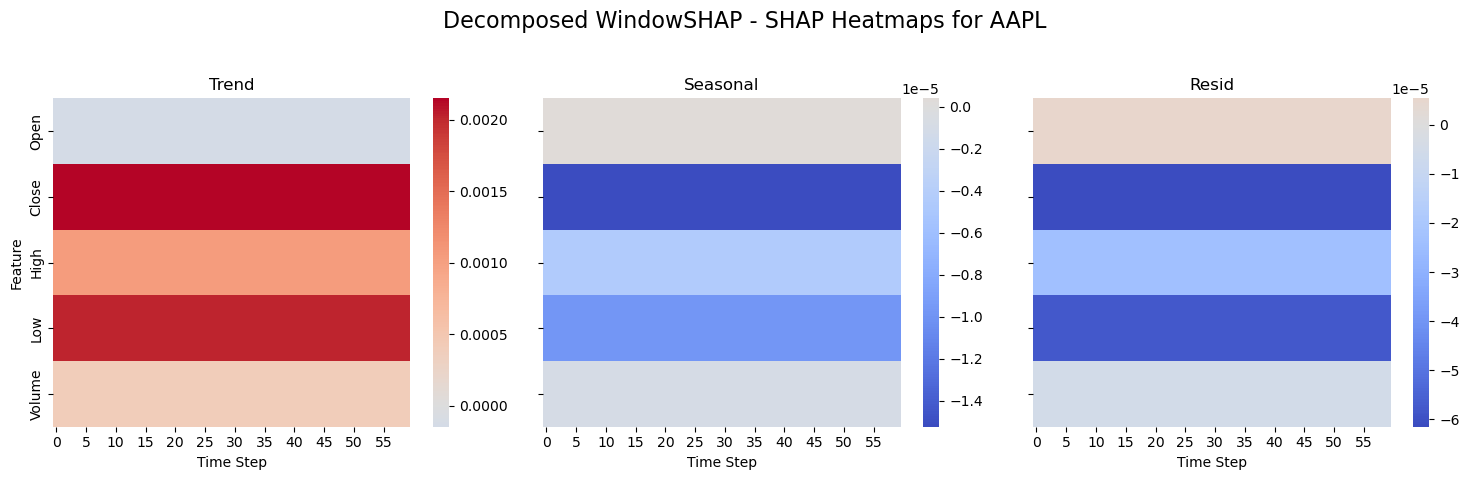

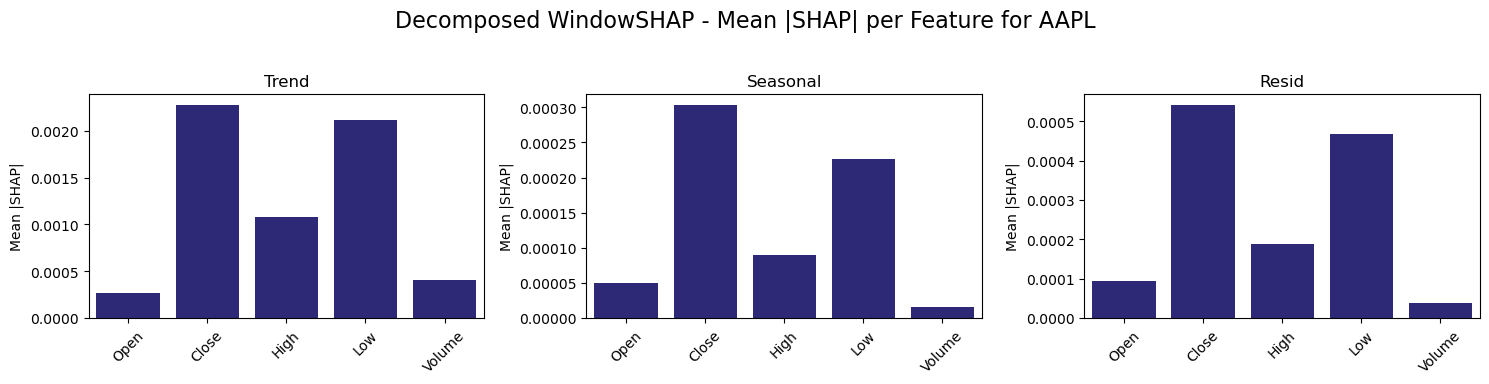

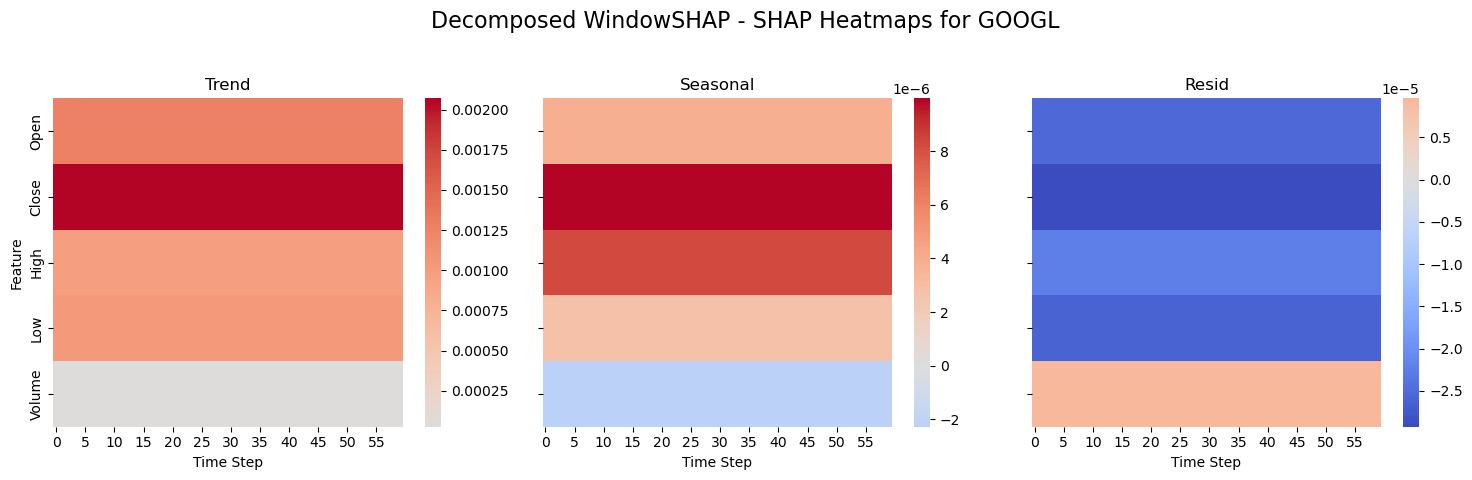

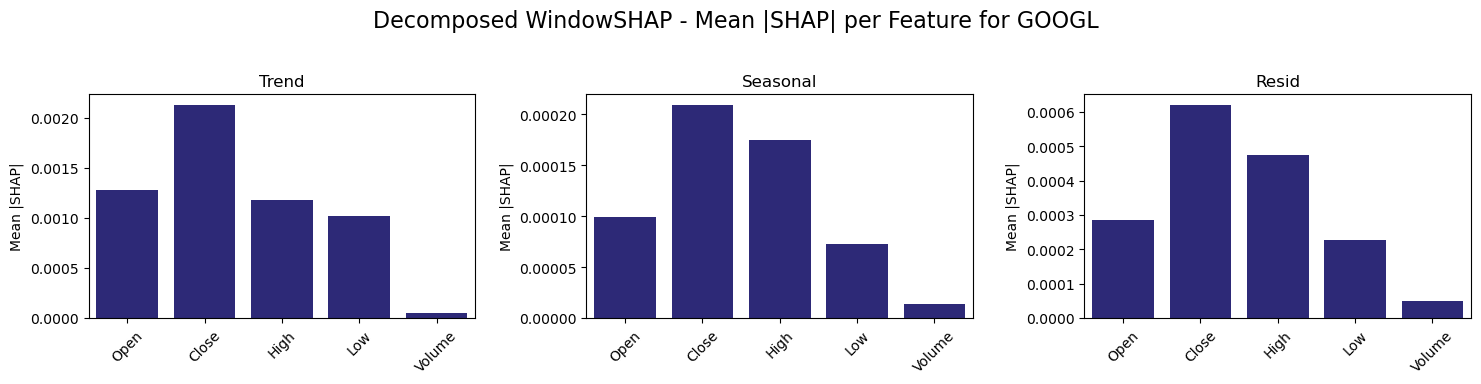

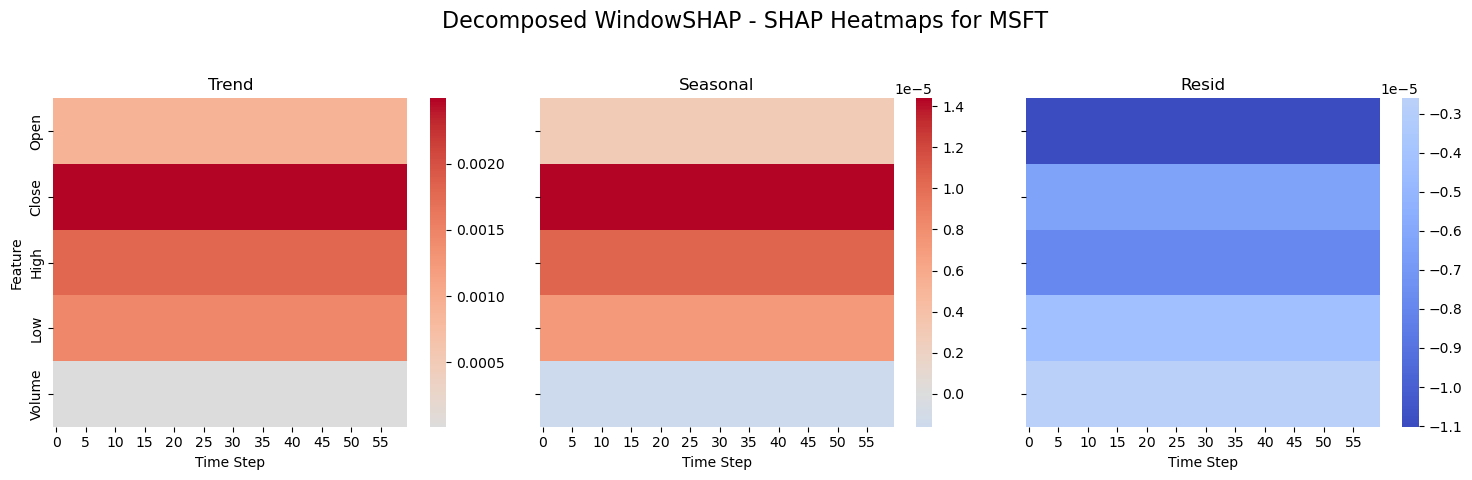

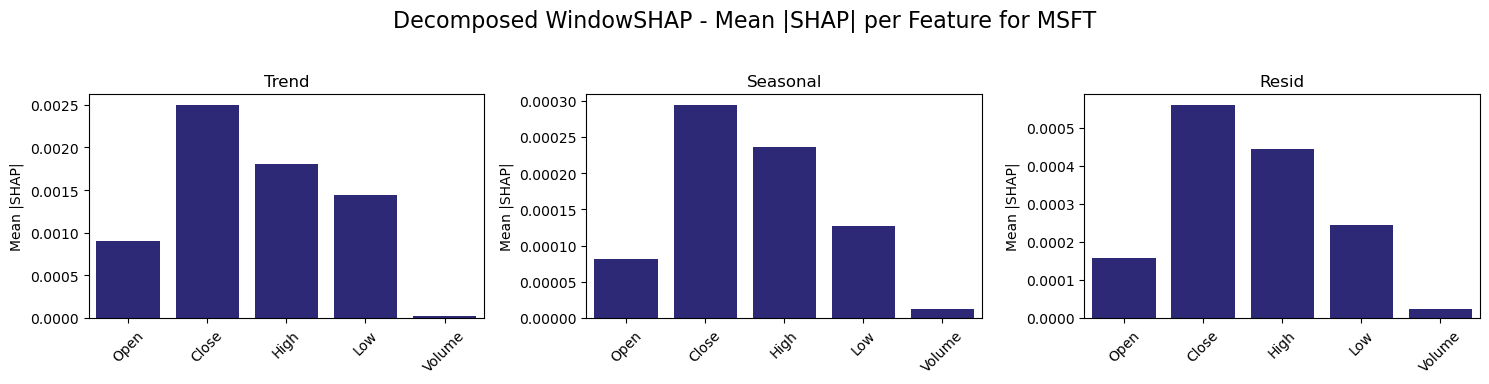

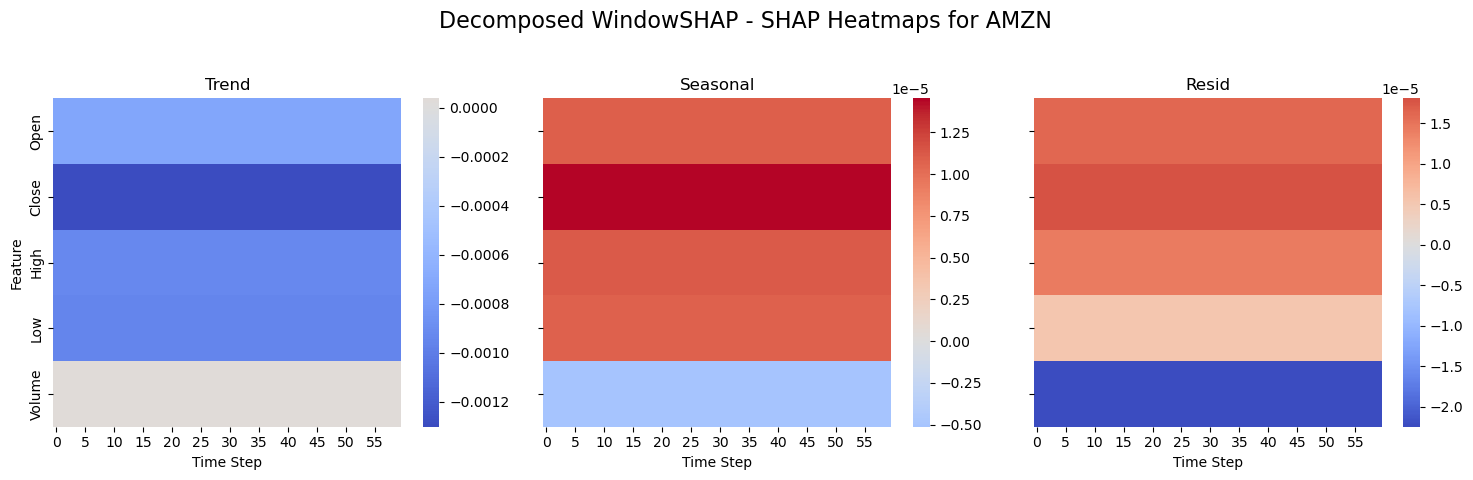

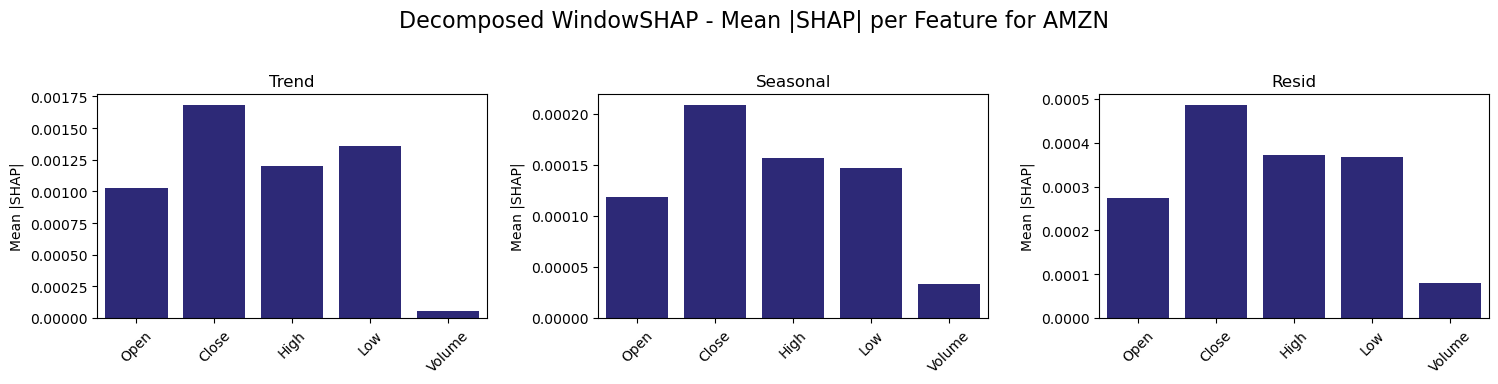

In [14]:
## Step 4 : Visualize values for each SHAP tool and ticker
shap.initjs()

top_features_per_ticker = {
    ticker: {} for ticker in tickers_list
}

for ticker in tickers_list:
    print(f"\n--- {ticker} ---")

    for tool in shap_tools:
        if tool == 'Decomposed_WindowSHAP':
            decomposed_feature_shap = {}

            fig_heat, axes_heat = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
            fig_heat.suptitle(f'Decomposed WindowSHAP - SHAP Heatmaps for {ticker}', fontsize=16)

            fig_bar, axes_bar = plt.subplots(1, 3, figsize=(15, 4))
            fig_bar.suptitle(f'Decomposed WindowSHAP - Mean |SHAP| per Feature for {ticker}', fontsize=16)


            for i, component in enumerate(shap_per_ticker[ticker][tool].keys()):

                shap_values = shap_per_ticker[ticker][tool][component]
                avg_shap = np.mean(shap_values, axis=0)
                avg_shap = np.squeeze(avg_shap)
                abs_avg_shap = np.mean(np.abs(shap_values), axis=(0, 1))
                abs_avg_shap = np.squeeze(abs_avg_shap)

                # Heatmap of Average SHAP Values
                # --- HEATMAP subplot ---
                sns.heatmap(
                    avg_shap.T,
                    xticklabels=5,
                    yticklabels=included_features,
                    cmap='coolwarm',
                    center=0,
                    annot=False,
                    ax=axes_heat[i]
                )
                axes_heat[i].set_title(component.capitalize())
                axes_heat[i].set_xlabel("Time Step")
                if i == 0:
                    axes_heat[i].set_ylabel("Feature")

                # Bar Plot of Average SHAP Values, with absolute values
                sns.barplot(x=included_features, y=abs_avg_shap, ax=axes_bar[i])
                axes_bar[i].set_title(component.capitalize())
                axes_bar[i].set_ylabel("Mean |SHAP|")
                axes_bar[i].tick_params(axis='x', rotation=45)

                # Top 3 features based on mean absolute SHAP values
                for j, base_feature in enumerate(included_features):
                    feature_name = f"{base_feature}_{component}"
                    decomposed_feature_shap[feature_name] = abs_avg_shap[j]

            sorted_features = sorted(decomposed_feature_shap.items(), key=lambda x: x[1], reverse=True)
            top3_decomposed_features = [feat for feat, score in sorted_features[:3]]
            top_features_per_ticker[ticker]['Decomposed_WindowSHAP'] = top3_decomposed_features
            print(f"Top {tool} Features for {ticker}: {top3_decomposed_features}")

            fig_heat.tight_layout(rect=[0, 0.03, 1, 0.95])
            fig_bar.tight_layout(rect=[0, 0.03, 1, 0.95])

            fig_heat.savefig(f"{figure_folder_path}/{ticker}_heatmap_for_{tool}.png")
            fig_bar.savefig(f"{figure_folder_path}/{ticker}_barplot_for_{tool}.png")

        else:

            shap_vals = shap_per_ticker[ticker][tool]
            avg_shap = np.mean(shap_vals, axis=0)
            avg_shap = np.squeeze(avg_shap)
            abs_avg_shap = np.mean(np.abs(shap_vals), axis=(0, 1))
            abs_avg_shap = np.squeeze(abs_avg_shap)

            # Heatmap of Average SHAP Values
            plt.figure(figsize=(10, 5))
            sns.heatmap(
                avg_shap.T,
                xticklabels=5,
                yticklabels=included_features,
                cmap='coolwarm',
                center=0
            )
            plt.title(f'{tool} - Average Values over Time for {ticker}')
            plt.xlabel('Time Step')
            plt.ylabel('Feature')
            plt.tight_layout()
            plt.savefig(f"{figure_folder_path}/{ticker}_heatmap_for_{tool}.png")
            plt.close()

            # Bar Plot of Average SHAP Values, with abosolute values
            plt.figure(figsize=(8, 4))
            sns.barplot(x=included_features, y=abs_avg_shap)
            plt.title(f'{tool} - Mean Absolute Value per Feature for {ticker}')
            plt.ylabel('Mean |SHAP|')
            plt.tight_layout()
            plt.savefig(f"{figure_folder_path}/{ticker}_barplot_for_{tool}.png")
            plt.close()

            # Top 3 features based on mean absolute SHAP values
            top3_idx = np.argsort(-abs_avg_shap)[:3]
            top3_features = [included_features[i] for i in top3_idx]
            top_features_per_ticker[ticker][tool] = top3_features
            print(f"Top {tool} Features for {ticker}: {top3_features}")


In [17]:
### Step 5.1 : Re-run LSTM using top 3 SHAP features from each tool for each ticker

for tool in shap_tools:
    print(f"\nRe-running LSTM with Top {tool} Features")
    eval_metrics_per_ticker = {}

    for ticker in tickers_list:
        print(f"\nProcessing {ticker}...")
        start_time = time.time()
        process = psutil.Process(os.getpid())
        start_ram = process.memory_info().rss / (1024 * 1024)

        top3_features = top_features_per_ticker[ticker][tool]

        if tool != 'Decomposed_WindowSHAP':
            full_df = data_per_ticker[ticker].df[top3_features] 
            ticker_subset = TickerData(full_df)
            X_train, y_train = ticker_subset.X_train, ticker_subset.y_train
            X_test, y_test = ticker_subset.X_test, ticker_subset.y_test

        else:
            components = ['trend', 'seasonal', 'resid']
            base_feats = included_features

            def get_decomposed_data(ticker, features, dataset_type='train'):
                data_list = []
                for feat_comp in features:

                    base_feat, comp = feat_comp.rsplit('_', 1)

                    if dataset_type == 'train':
                        if comp == 'trend':
                            data_comp = data_per_ticker[ticker].X_train_trend[:, :, base_feats.index(base_feat)]
                        elif comp == 'seasonal':
                            data_comp = data_per_ticker[ticker].X_train_seasonal[:, :, base_feats.index(base_feat)]
                        elif comp == 'resid':
                            data_comp = data_per_ticker[ticker].X_train_residual[:, :, base_feats.index(base_feat)]
                    else:  # test
                        if comp == 'trend':
                            data_comp = data_per_ticker[ticker].X_test_trend[:, :, base_feats.index(base_feat)]
                        elif comp == 'seasonal':
                            data_comp = data_per_ticker[ticker].X_test_seasonal[:, :, base_feats.index(base_feat)]
                        elif comp == 'resid':
                            data_comp = data_per_ticker[ticker].X_test_residual[:, :, base_feats.index(base_feat)]

                    data_list.append(data_comp)

                return np.stack(data_list, axis=2)

            X_train = get_decomposed_data(ticker, top3_features, 'train')
            y_train = data_per_ticker[ticker].y_train
            X_test = get_decomposed_data(ticker, top3_features, 'test')
            y_test = data_per_ticker[ticker].y_test

        model = build_model((n_window_size, X_train.shape[2]))
        model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0)

        inv_y_pred, inv_y_test = gen_store_predictions(model, X_test, y_test, ticker)
        mae, mse, rmse, mape = evaluate_predictions(inv_y_pred, inv_y_test)

        end_time = time.time()
        end_ram = process.memory_info().rss / (1024 * 1024)

        total_time = end_time - start_time
        total_ram = end_ram - start_ram

        memory_usage = process.memory_info().rss / (1024 * 1024)

        model_per_ticker[ticker][tool] = {
        'model': model,
        'runtime': total_time,
        'memory_usage': total_ram,
        'y_pred': inv_y_pred,
        'y_test': inv_y_test,
        'metrics': {
            'mae': mae,
            'mse': mse,
            'rmse': rmse,
            'mape': mape
        }}

print('LSTM re-computation complete.')


Re-running LSTM with Top SHAP Features

Processing AAPL...

Processing GOOGL...

Processing MSFT...

Processing AMZN...

Re-running LSTM with Top WindowSHAP Features

Processing AAPL...

Processing GOOGL...

Processing MSFT...

Processing AMZN...

Re-running LSTM with Top Decomposed_WindowSHAP Features

Processing AAPL...

Processing GOOGL...

Processing MSFT...

Processing AMZN...
LSTM re-computation complete.


In [21]:
# Step 5.2 : Compute evaluation metrics 

for tool in shap_tools:
    metrics_df = pd.DataFrame({
        ticker: model_per_ticker[ticker][tool]['metrics']
        for ticker in model_per_ticker
    }).T

    metrics_df = metrics_df[['mae', 'mse', 'rmse', 'mape']]

    print(f"\nLSTM Evaluation Metrics -- Based on {tool}:\n")
    print(metrics_df.to_string(float_format='%.4f'))


LSTM Evaluation Metrics -- Based on SHAP:

          mae      mse    rmse   mape
AAPL   5.1515  52.4099  7.2395 3.7260
GOOGL  5.2928  49.4039  7.0288 5.1173
MSFT  15.4865 421.8821 20.5398 5.5790
AMZN   5.0894  44.7187  6.6872 4.1234

LSTM Evaluation Metrics -- Based on WindowSHAP:

          mae      mse    rmse   mape
AAPL   5.2400  55.4443  7.4461 3.8173
GOOGL  5.3113  49.3245  7.0231 5.1173
MSFT  12.9420 318.2935 17.8408 4.6595
AMZN   6.0631  59.4781  7.7122 4.9322

LSTM Evaluation Metrics -- Based on Decomposed_WindowSHAP:

          mae       mse    rmse   mape
AAPL   9.2832  149.0485 12.2085 6.5060
GOOGL 10.2210  157.9570 12.5681 9.7101
MSFT  27.4231 1080.2931 32.8678 9.4196
AMZN   8.9315  134.5844 11.6011 7.3071
